In [70]:
#  Load required library packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline

color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') 

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))

PREDICT_HOUR = 6

1-ny-taxi-data-exploration-and-visualization.ipynb
fare_data.csv
input
nb-analysis.ipynb
ny-predict-taxi-demand-Boosted-Decision-tree.ipynb
ny-predict-taxi-demand-Linear-Regression-3-lag.ipynb
ny-predict-taxi-demand-Linear-Regression-full.ipynb
ny-predict-taxi-demand-Random-Forest.ipynb
ny-predict-taxi-demand-baseline.ipynb
ny-predict-taxi-demand.ipynb
trip_data.csv



In [71]:
# Load trip data csv
df_trip = pd.read_csv('input/trip_data.csv',
                      parse_dates=['pickup_datetime', 
                                        'dropoff_datetime'])
print(df_trip.shape)
df_trip.head()
print(df_trip.vendor_id.unique())

(13059961, 14)
['CMT' 'VTS']


In [72]:
# clean data
df_trip_indexed = df_trip.reset_index()

# Remove null values
df_trip_indexed = df_trip_indexed.dropna()

# Remove trips with zero passengers
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.passenger_count < 0].index)

# Remove trips with time less than zero
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs < 0].index)

# Remove trips with time greater than 10 hours
df_trip_indexed = df_trip_indexed.drop(df_trip_indexed[df_trip_indexed.trip_time_in_secs > 36000].index)


In [73]:
# Generate features based on pickup hour
df_trip_indexed['trip_date'] = df_trip_indexed['pickup_datetime'].dt.date
df_trip_indexed['trip_hour'] = df_trip_indexed['pickup_datetime'].dt.hour
#df = pd.DataFrame(df_trip_indexed.groupby(['pickup_datetime.dt.hour']).count()['index'])
df_trip_indexed.head()


,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_date,trip_hour
0,0,001DFAC01BC0A32F48C3769DD1414778,5A677E8D42137D0006944AF0E4D4488C,CMT,1,N,2013-01-19 12:37:55,2013-01-19 12:51:26,3,810,3.1,-73.988869,40.736645,-73.957756,40.768227,2013-01-19,12
1,1,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,1,N,2013-01-18 15:16:11,2013-01-18 15:32:51,1,1000,2.6,-73.967781,40.762726,-73.976303,40.788666,2013-01-18,15
2,2,001DFAC01BC0A32F48C3769DD1414778,EB99F192B7EA48BE077EE152BB630A4E,CMT,5,N,2013-01-18 15:34:56,2013-01-18 16:21:18,1,2782,18.3,-73.974121,40.791367,-74.184647,40.692551,2013-01-18,15
3,3,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,5,N,2013-01-18 23:06:21,2013-01-18 23:26:43,1,1221,5.1,-73.987343,40.738934,-74.035683,40.716774,2013-01-18,23
4,4,001DFAC01BC0A32F48C3769DD1414778,AAB8A9FBE9CF2DDCB146CC6EFEDD772F,CMT,1,N,2013-01-18 22:18:20,2013-01-18 22:32:08,1,828,3.4,-73.956642,40.771252,-73.955116,40.741486,2013-01-18,22


In [74]:
# Generate trips per hour 
temp = df_trip_indexed.drop(['medallion','hack_license','vendor_id', 'pickup_datetime' ,'rate_code', 'store_and_fwd_flag', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=False)
df_trips_ph = pd.DataFrame(temp.groupby(['trip_date', 'trip_hour']).count().reset_index())
df_trips_ph.columns = ['pickup_date', 'pickup_hour', 'trips']
df_trips_ph.head()


,pickup_date,pickup_hour,trips
0,2013-01-01,0,1206
1,2013-01-01,1,1334
2,2013-01-01,2,1203
3,2013-01-01,3,1071
4,2013-01-01,4,781


In [75]:
#df_trips_ph['p_datetime'] =  df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['pickup_hour'].astype(str)
#df_trips_ph.head()

df_trips_ph['time'] = df_trips_ph['pickup_hour'].apply(lambda x: "0{0}:00:00".format(x))
df_trips_ph['pickup_dt'] = pd.to_datetime(df_trips_ph['pickup_date'].astype(str) + ' ' + df_trips_ph['time'])
df_trips_ph = df_trips_ph.drop(['time'], axis=1, inplace=False)

df_trips_ph['target_hour'] = (df_trips_ph["pickup_hour"] + PREDICT_HOUR)%24
df_trips_ph.head()


,pickup_date,pickup_hour,trips,pickup_dt,target_hour
0,2013-01-01,0,1206,2013-01-01 00:00:00,6
1,2013-01-01,1,1334,2013-01-01 01:00:00,7
2,2013-01-01,2,1203,2013-01-01 02:00:00,8
3,2013-01-01,3,1071,2013-01-01 03:00:00,9
4,2013-01-01,4,781,2013-01-01 04:00:00,10


In [77]:
df_trips_ph['target_dt'] = df_trips_ph.pickup_dt + pd.to_timedelta(PREDICT_HOUR, unit='h')
df_trips_ph.head()

,pickup_date,pickup_hour,trips,pickup_dt,target_hour,target_dt
0,2013-01-01,0,1206,2013-01-01 00:00:00,6,2013-01-01 06:00:00
1,2013-01-01,1,1334,2013-01-01 01:00:00,7,2013-01-01 07:00:00
2,2013-01-01,2,1203,2013-01-01 02:00:00,8,2013-01-01 08:00:00
3,2013-01-01,3,1071,2013-01-01 03:00:00,9,2013-01-01 09:00:00
4,2013-01-01,4,781,2013-01-01 04:00:00,10,2013-01-01 10:00:00


In [78]:
temp = df_trips_ph
df_join = pd.merge(temp, df_trips_ph, left_on='target_dt', right_on='pickup_dt', how='inner')

#df_join.head(20)
result = df_join.drop([ 'pickup_date_y', 'pickup_hour_y','target_hour_y' , 'target_dt_y', 'pickup_dt_y'], axis=1, inplace=False)
result.columns = ['pickup_date', 'pickup_hour', 'pickup_trips','pickup_dt', 'target_hour', 'target_dt', 'target_trips']
result['target_day'] = result['target_dt'].dt.day
result = result.drop([ 'pickup_date', 'pickup_hour','target_dt'], axis=1, inplace=False)
result = result.reset_index()
result.head(10)

,index,pickup_trips,pickup_dt,target_hour,target_trips,target_day
0,0,1206,2013-01-01 00:00:00,6,390,1
1,1,1334,2013-01-01 01:00:00,7,297,1
2,2,1203,2013-01-01 02:00:00,8,241,1
3,3,1071,2013-01-01 03:00:00,9,296,1
4,4,781,2013-01-01 04:00:00,10,410,1
5,5,440,2013-01-01 05:00:00,11,580,1
6,6,390,2013-01-01 06:00:00,12,723,1
7,7,297,2013-01-01 07:00:00,13,784,1
8,8,241,2013-01-01 08:00:00,14,809,1
9,9,296,2013-01-01 09:00:00,15,818,1


In [85]:
# Run least square regression on dataset
import statsmodels.formula.api as sm
result.columns
train = result.drop(['pickup_dt'], axis=1, inplace=False)
train.head()
res = sm.ols(formula="target_trips ~ target_hour + target_day + pickup_trips", data=train).fit()

In [86]:
print(res.params)

Intercept       582.908117
target_hour      30.651500
target_day       -0.944433
pickup_trips     -0.173931
dtype: float64


In [87]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           target_trips   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     2382.
Date:                Wed, 26 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:50:32   Log-Likelihood:                -60540.
No. Observations:                8728   AIC:                         1.211e+05
Df Residuals:                    8724   BIC:                         1.211e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      582.9081      9.767     59.682   

In [82]:
train['predicted_trips'] = res.fittedvalues
train.head()

,index,pickup_trips,target_hour,target_trips,target_day,predicted_trips
0,0,1206,6,390,1,556.112310
1,1,1334,7,297,1,564.500685
2,2,1203,8,241,1,617.937101
3,3,1071,9,296,1,671.547448
4,4,781,10,410,1,752.638839


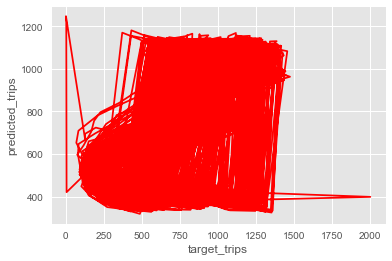

In [83]:
x = train['target_trips']
y = train['predicted_trips']
plt.plot(x, y, 'r-')
plt.xlabel('target_trips')
plt.ylabel('predicted_trips')
plt.show()

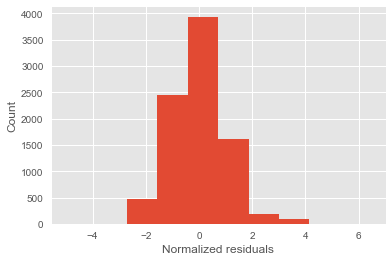

In [84]:
#fitted = res.fit()
plt.hist(res.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')